In [3]:
import SIMSIToolBox
import os
import matplotlib.pyplot as plt
from pyimzml.ImzMLParser import ImzMLParser, getionimage
import importlib
importlib.reload(SIMSIToolBox)
import numpy as np
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from copy import deepcopy

In [10]:
desiFile = "X:/MSI_Shared_Data/13CImagingManuscript/raw_data/non-perfused/desi/13C/20221107_mt_tumor_brain4-4_13B_13C_20um_70-560mz Analyte 1_1_recal.imzML"
maldiFile = "X:/MSI_Shared_Data/13CImagingManuscript/raw_data/non-perfused/maldi/13C/14x/4-4_10J-L_nedc_14x_50um_recal.imzML"


In [33]:
fns = [desiFile,maldiFile]
labels = ["DESI","MALDI"]
intensityCutoff = 400
ppm = 15
numCores = 20
dm_method = "PCA" #method for dimensionality reduction ("PCA" or "TSNE") PCA has worked better for me
seg_method = "K_means" #thresholding method ("TIC_auto", "K_means", "TIC_manual")
num_components = 2 #number of compoents to use with PCA or TSNE
colormap = LinearSegmentedColormap.from_list("test",colors=["black", "navy","blue","cyan","yellow","orange","orangered","red","mistyrose","white"],N=256)


In [13]:
imgs = []
ps = []
meanTics = []
for file in fns:
    p = ImzMLParser(file) #load data
    img = getionimage(p,174.0407175,0.01)
    ticImage = getionimage(p,500,1000)
    meanTic = np.median(ticImage)
    imgs.append(img)
    ps.append(p)
    meanTics.append(meanTic)

In [14]:
meanTics

[449096.5, 1194037.5]

In [15]:
factors = meanTics / meanTics[1]
factors

array([0.37611591, 1.        ])

 |██████████████████████████████████████████████████| 100.0% 11933 mzs detected

11933 m/z values detected in DESI
 |██████████████████████████████████████████████████| 100.0% 5410 mzs detected

5410 m/z values detected in MALDI


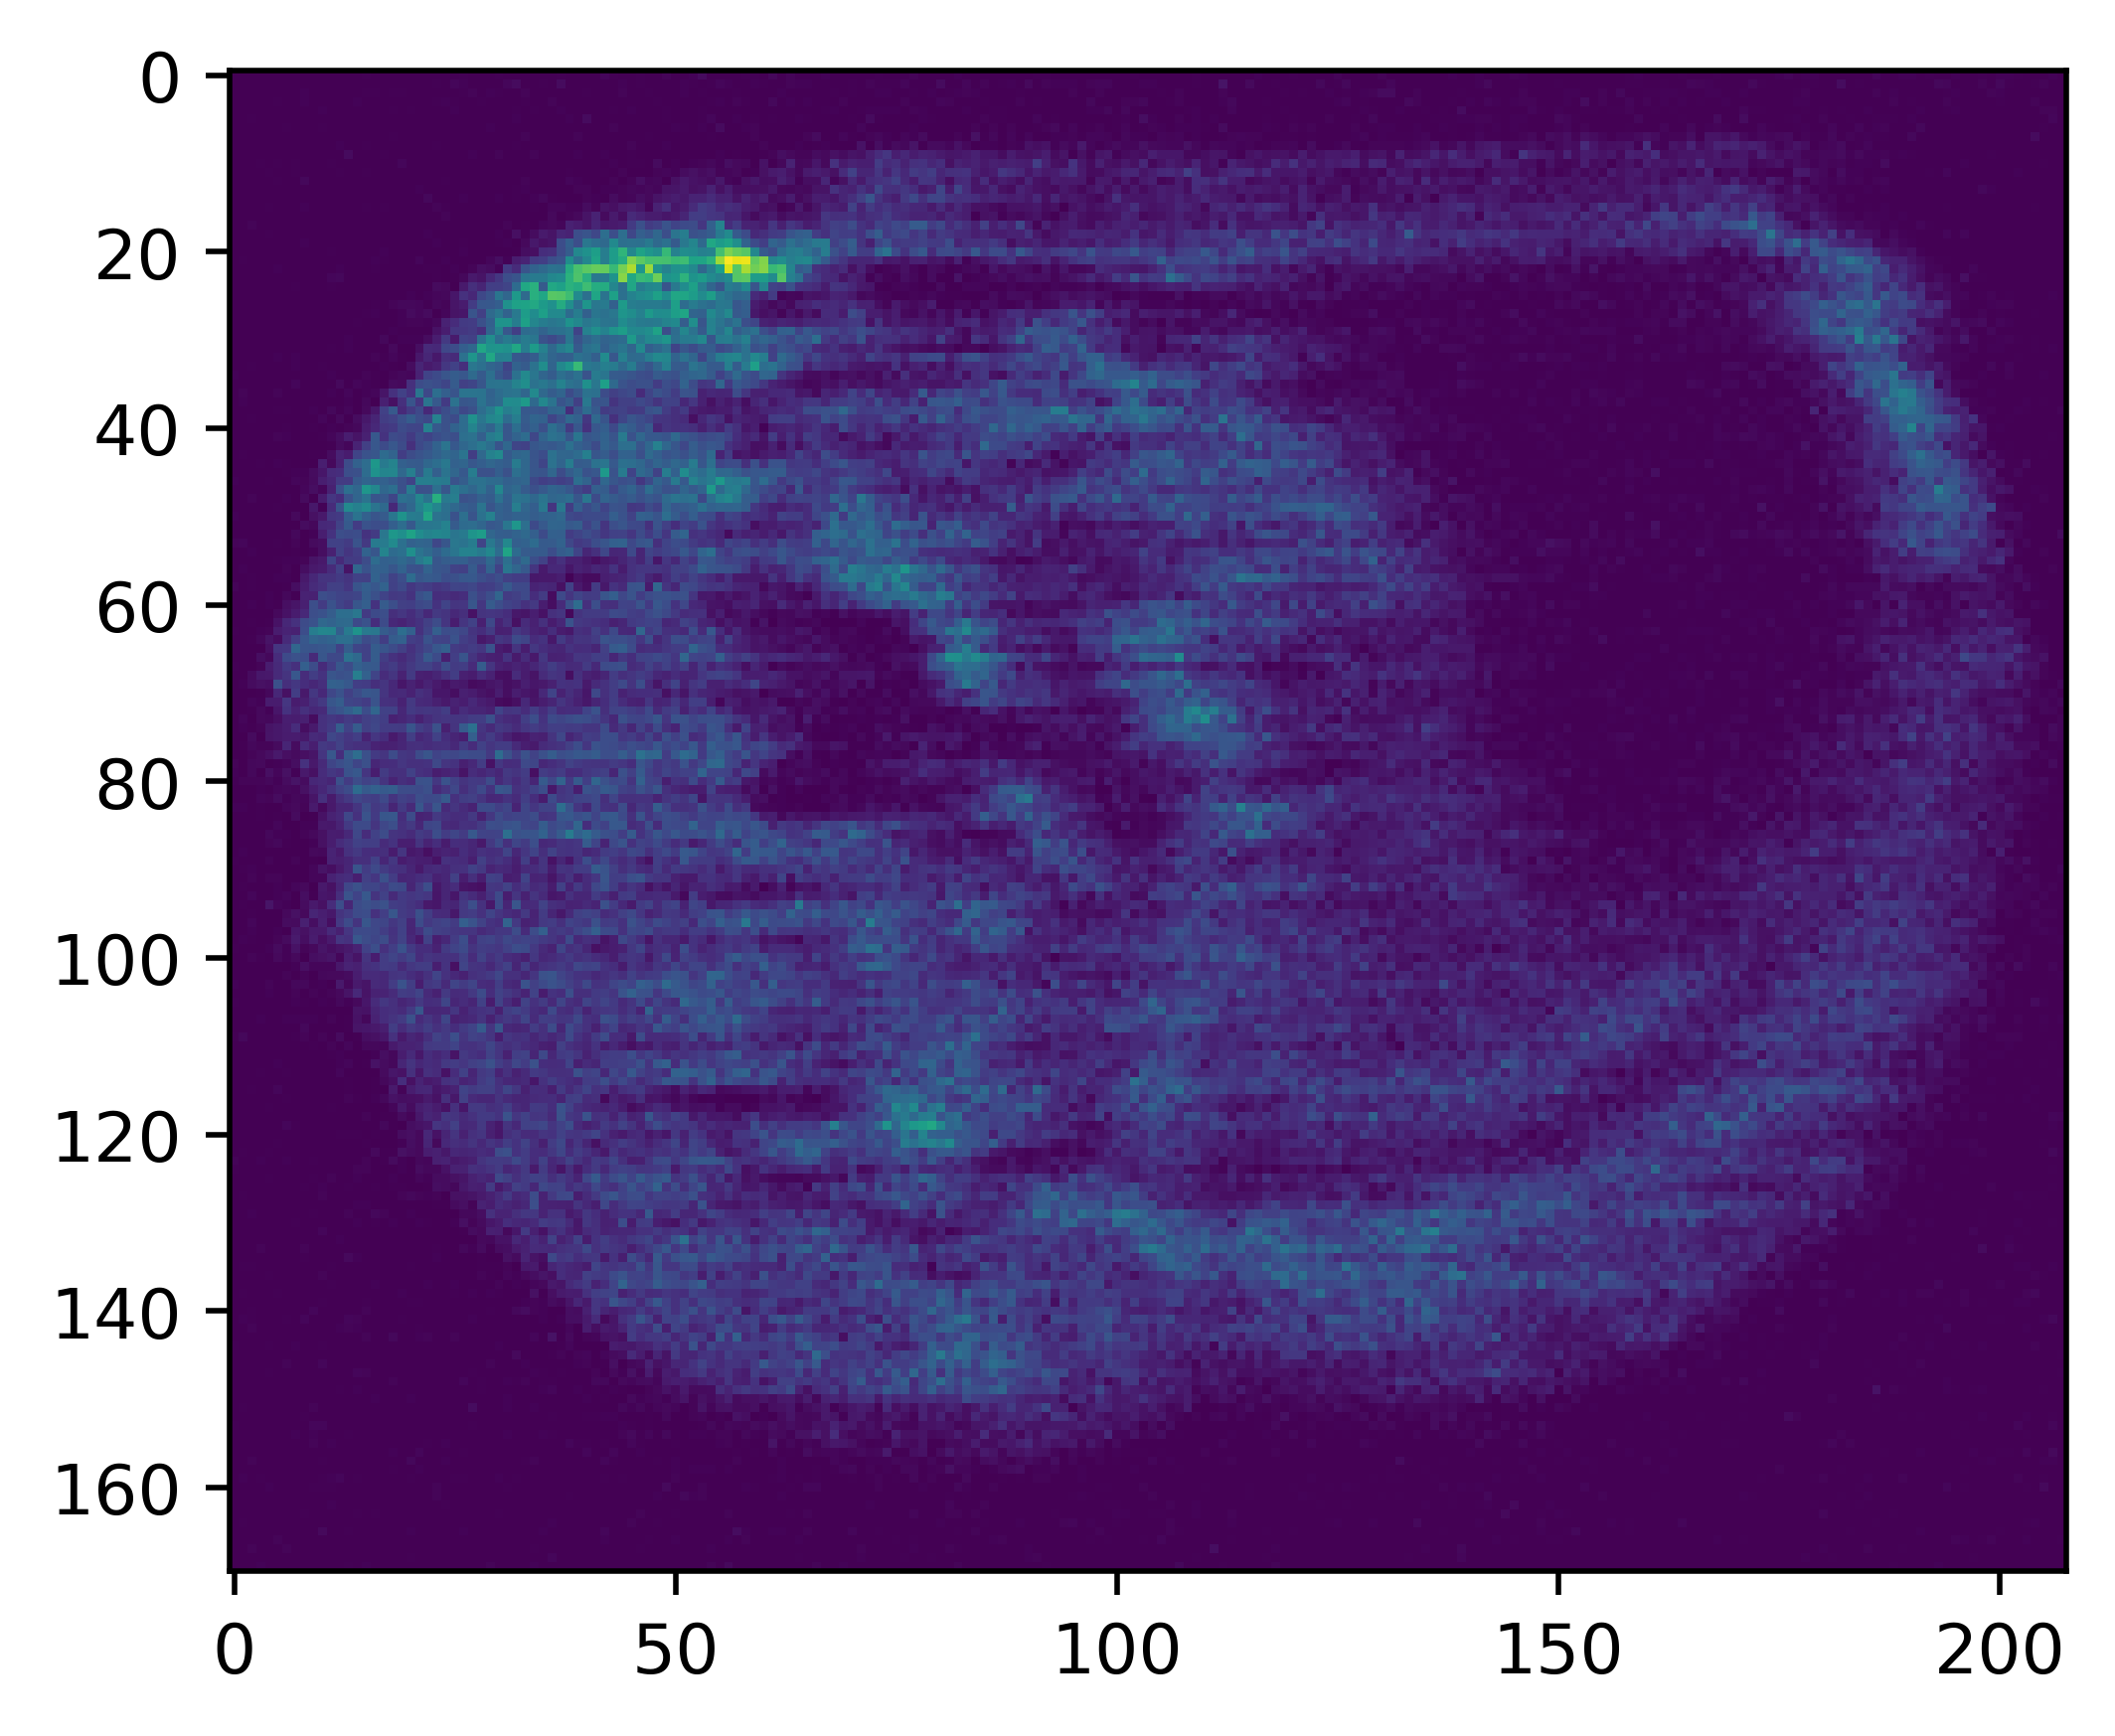

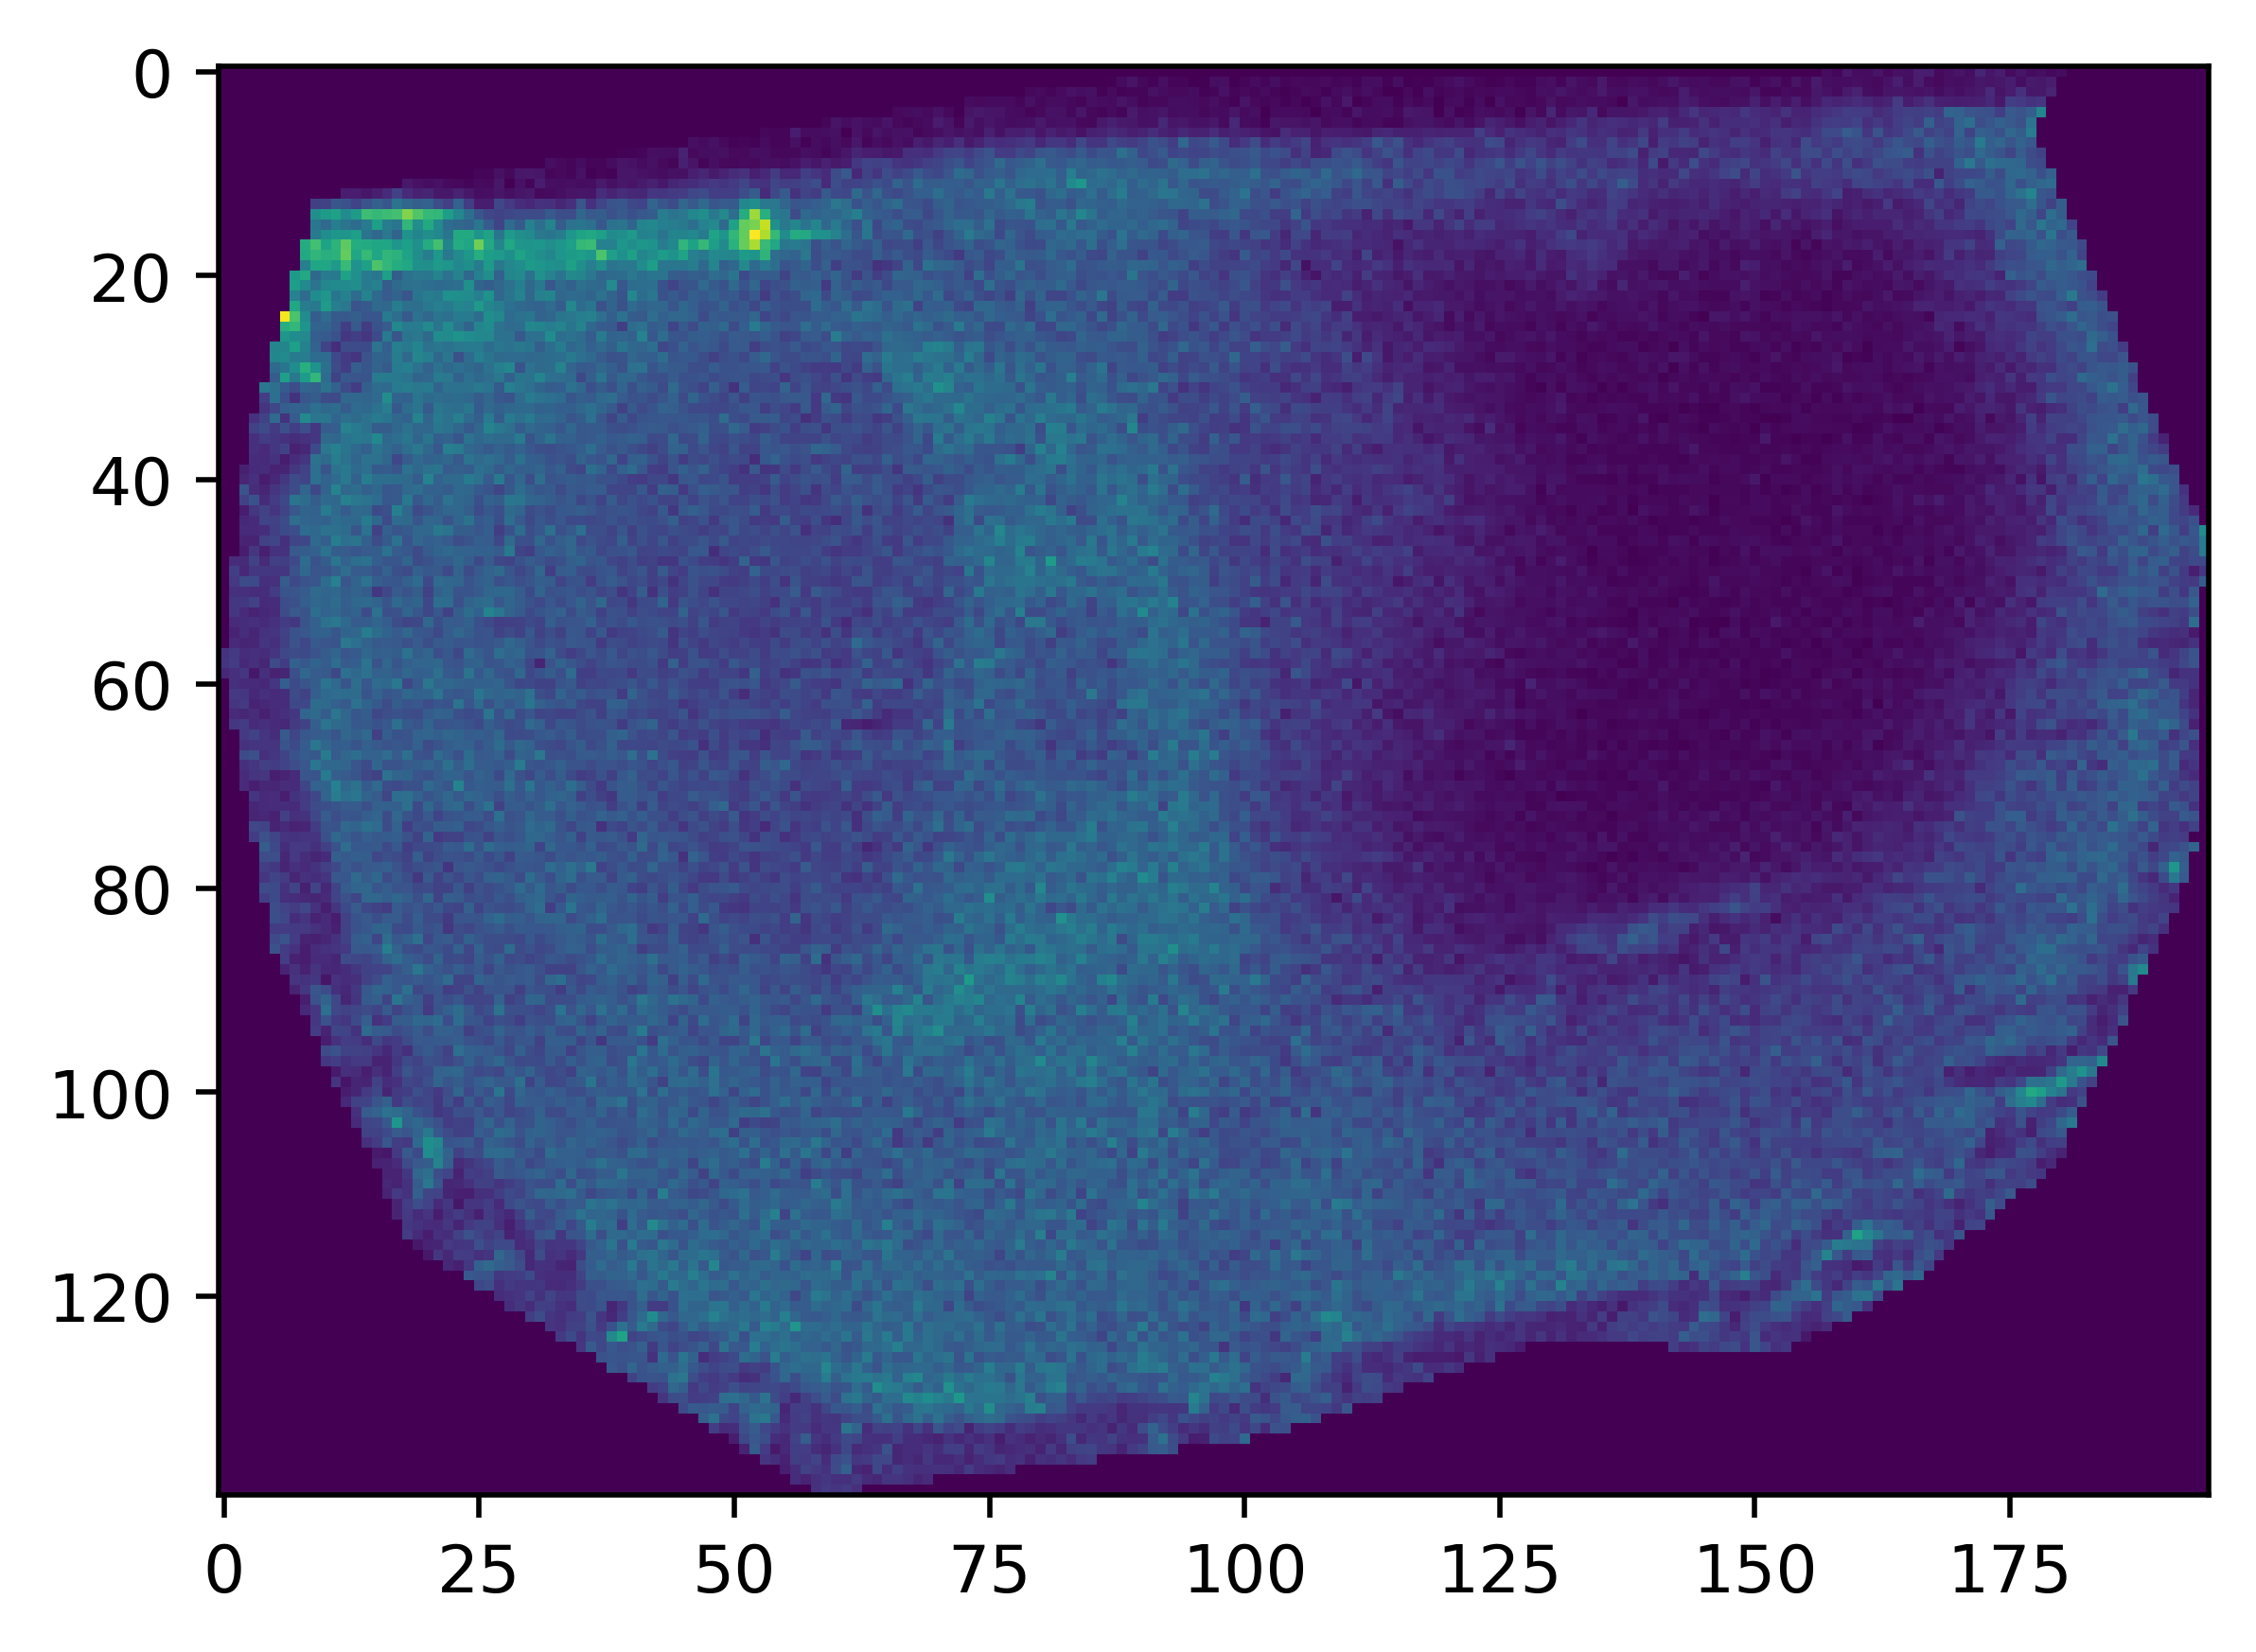

In [34]:
mzLists = []
for file,label,img,p,factor in zip(fns,labels,imgs,ps,factors):
    
    plt.figure()
    plt.imshow(img)
    
    #gather mzs of interest
    mzList = []
    i = 0
    
    for idx, (x,y,z) in enumerate(p.coordinates):
        mzs, intensities = p.getspectrum(idx)
        tmp = intensityCutoff * factor
        mzs = [mzs[x] for x in range(len(mzs)) if intensities[x] > tmp]
        mzList = SIMSIToolBox.mergeMzLists(mzList,mzs,ppm)
        i += 1
        SIMSIToolBox.printProgressBar(i,len(p.coordinates),printEnd="",suffix=str(len(mzList)) + " mzs detected")
        
    mzList.sort()
    mzLists.append(mzList)
    print()
    print(len(mzList), "m/z values detected in " + label)


extracting intensities |██████████████████████████████████████████████████| 100.0% 
forming matrix |██████████████████████████████████████████████████| 100.0% 
extracting intensities |██████████████████████████████████████████████████| 100.0% 
forming matrix |██████████████████████████████████████████████████| 100.0% 


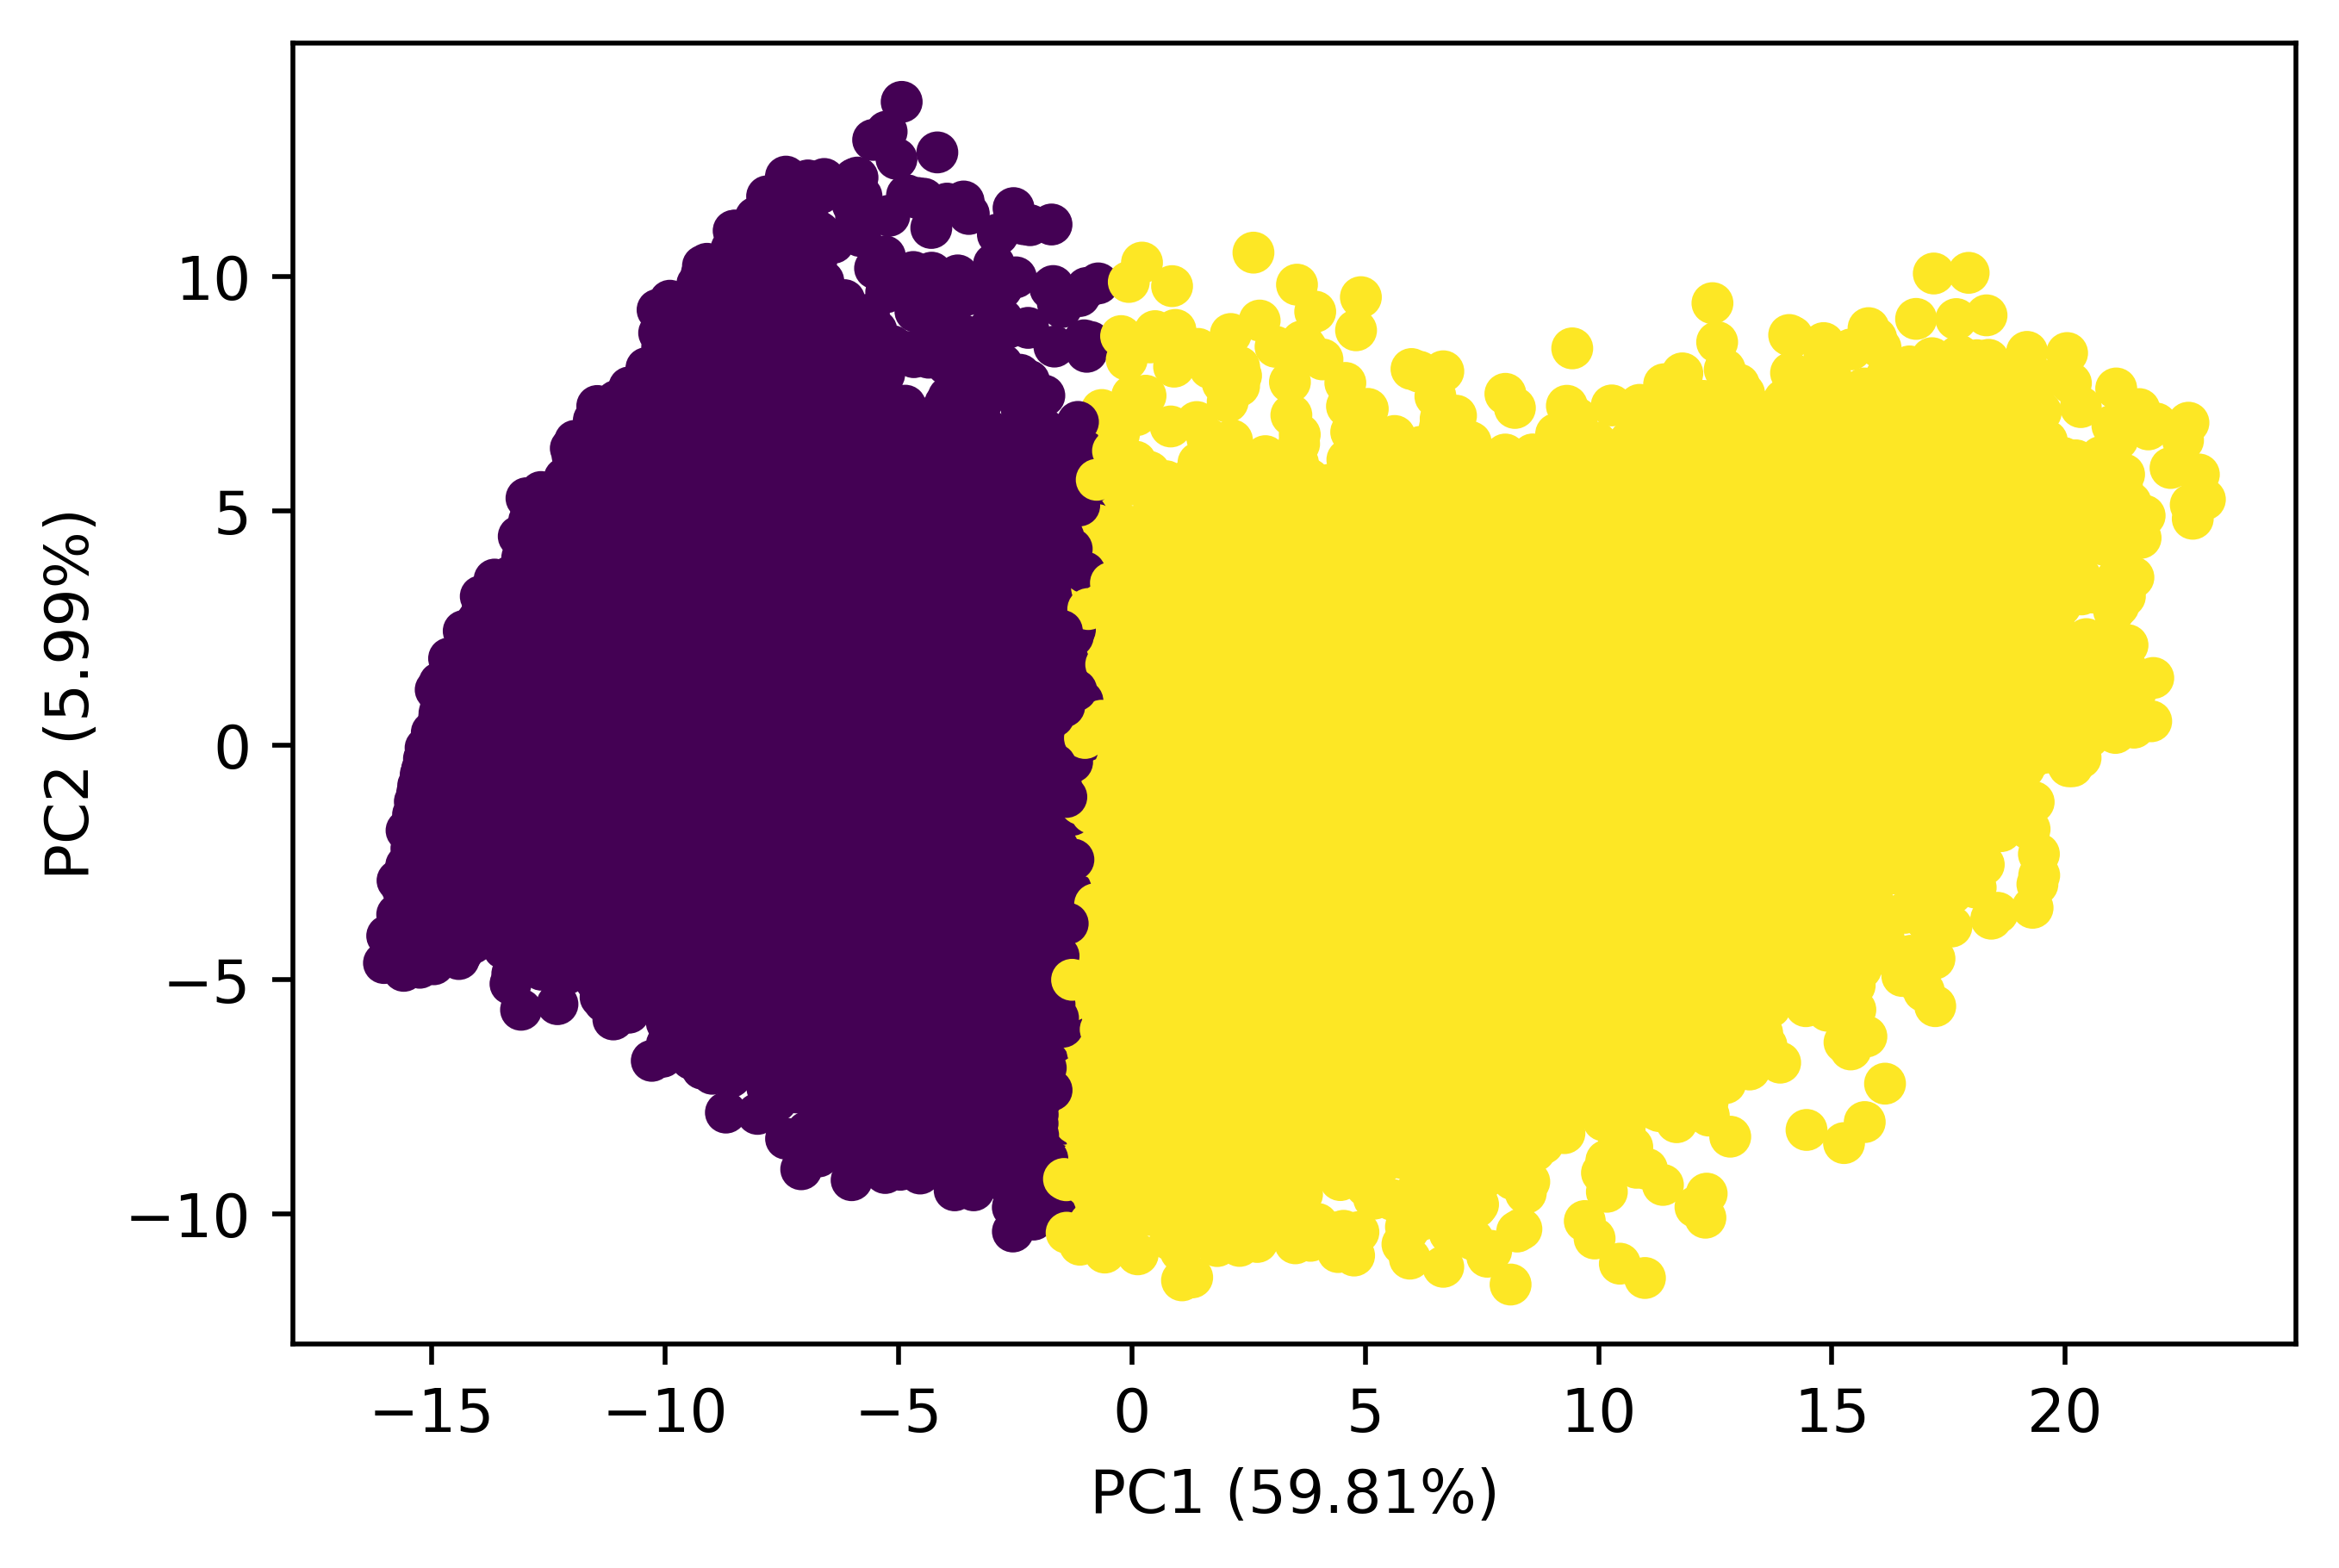

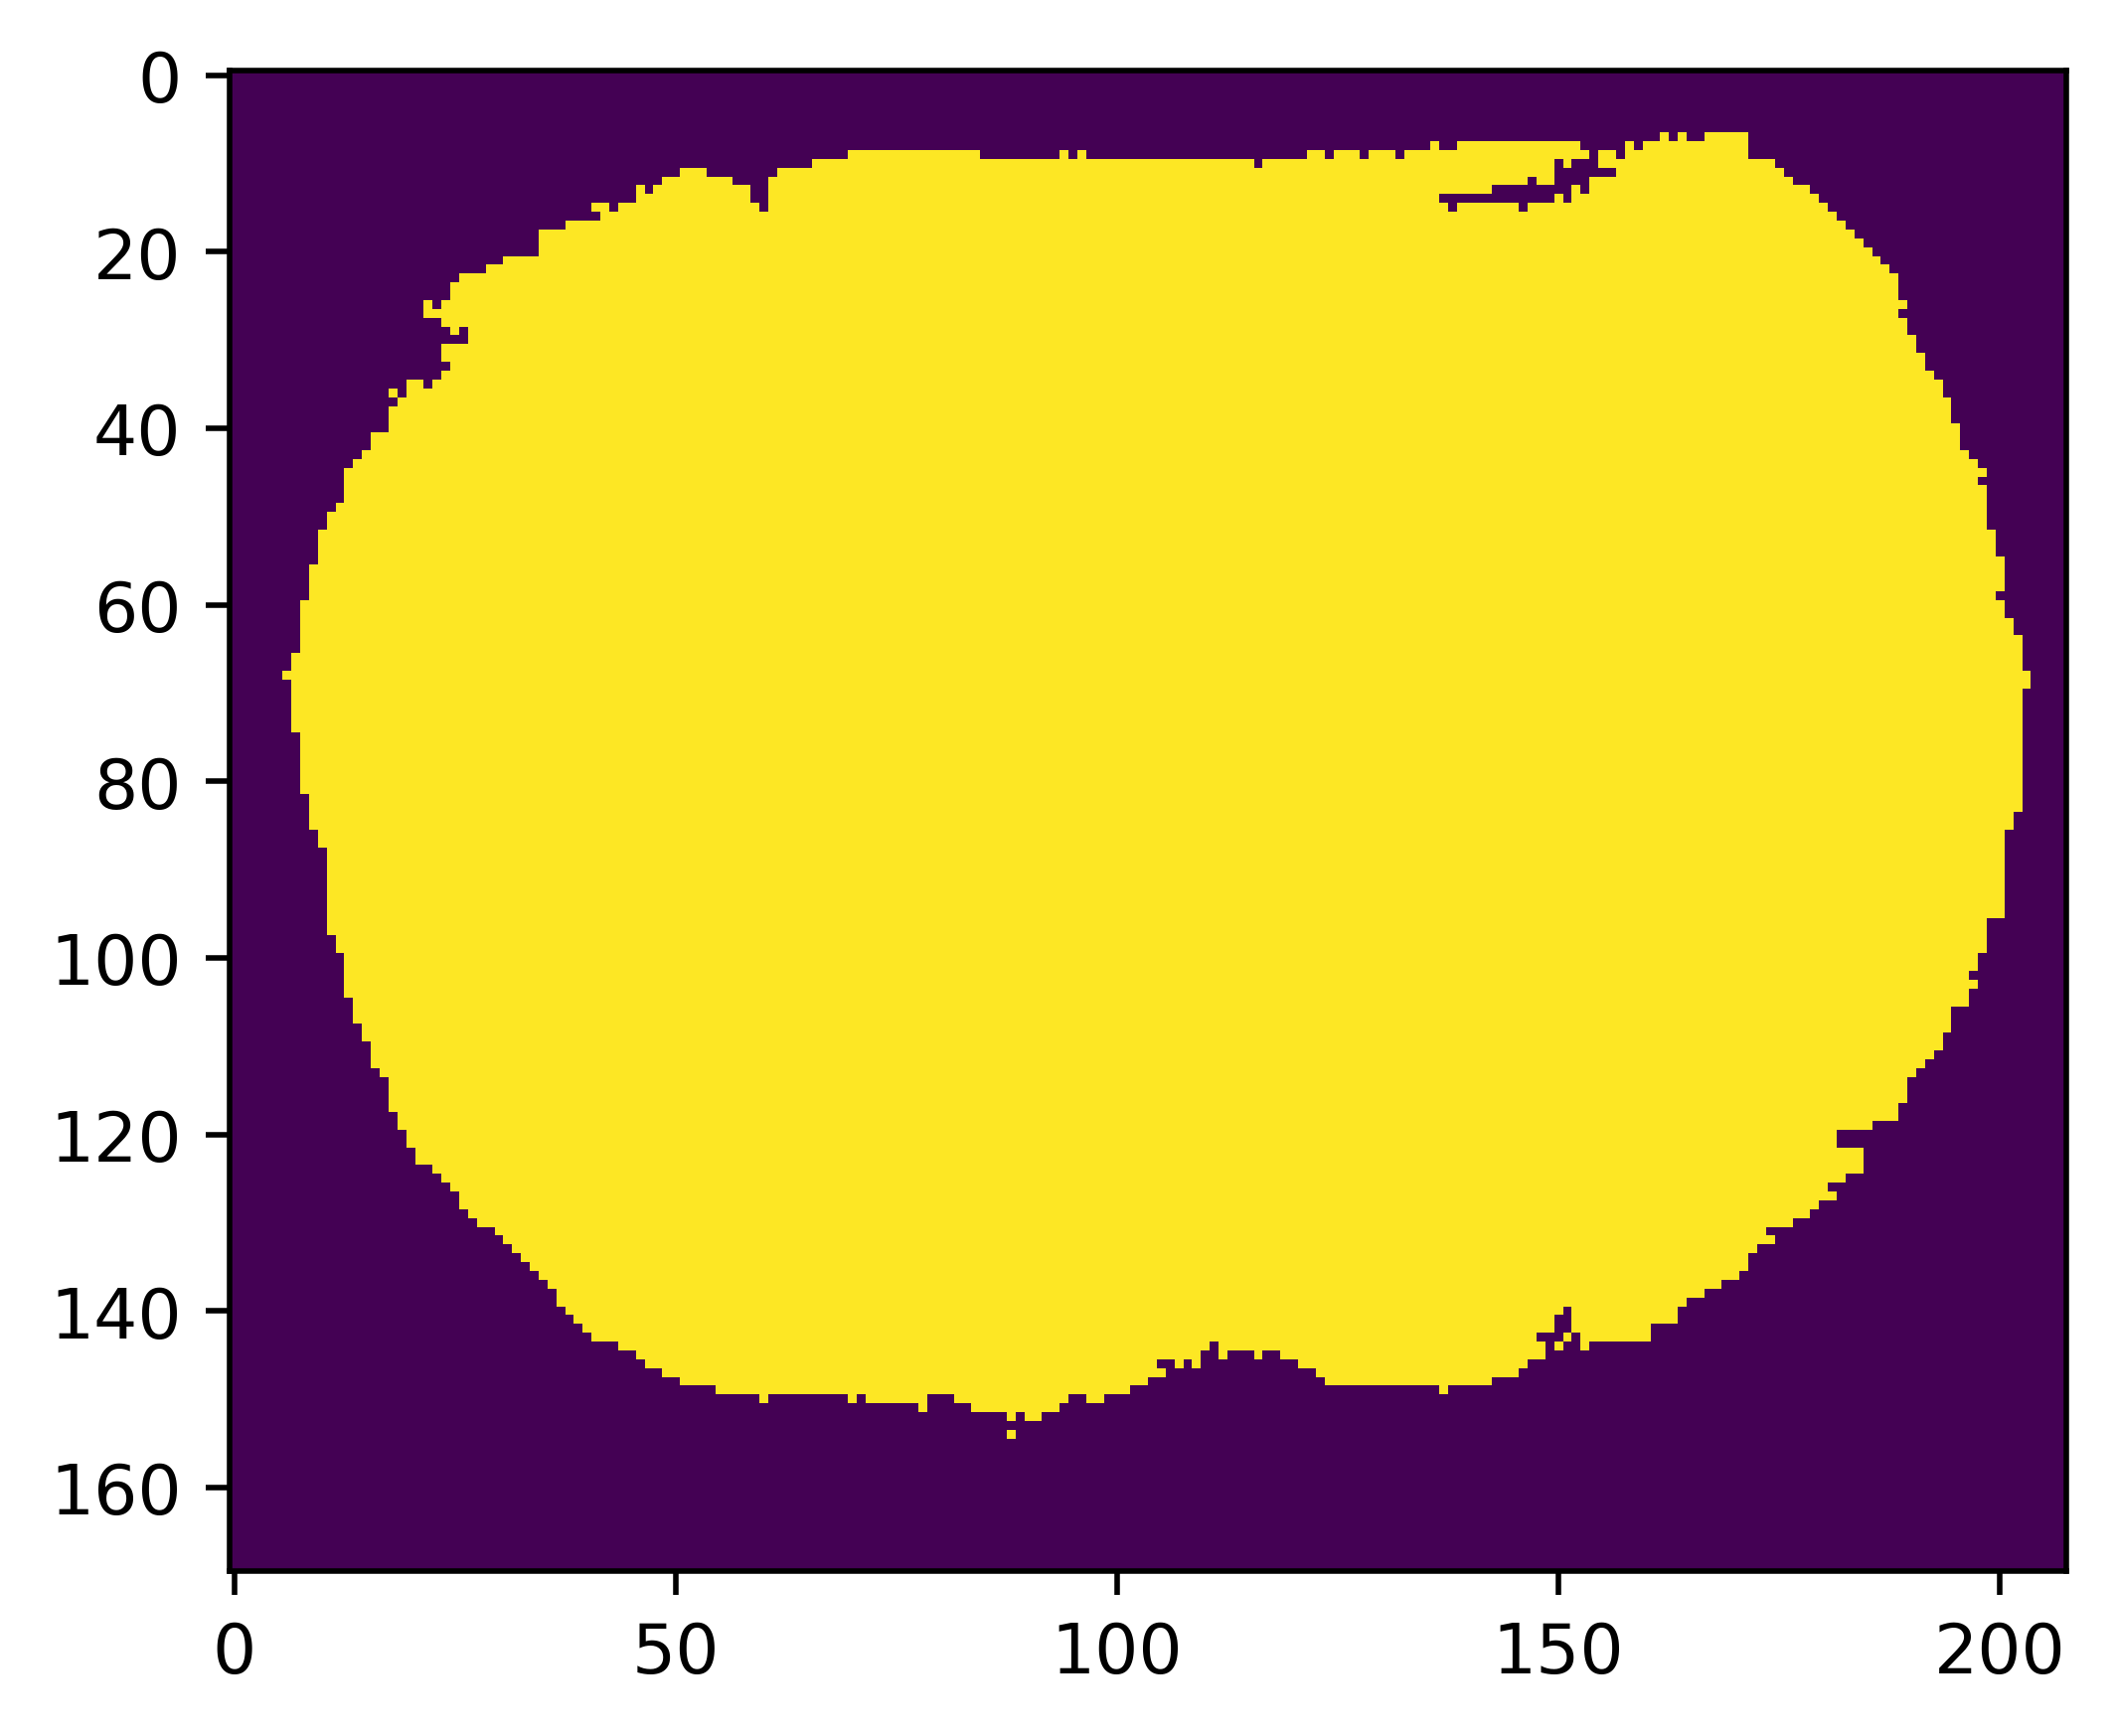

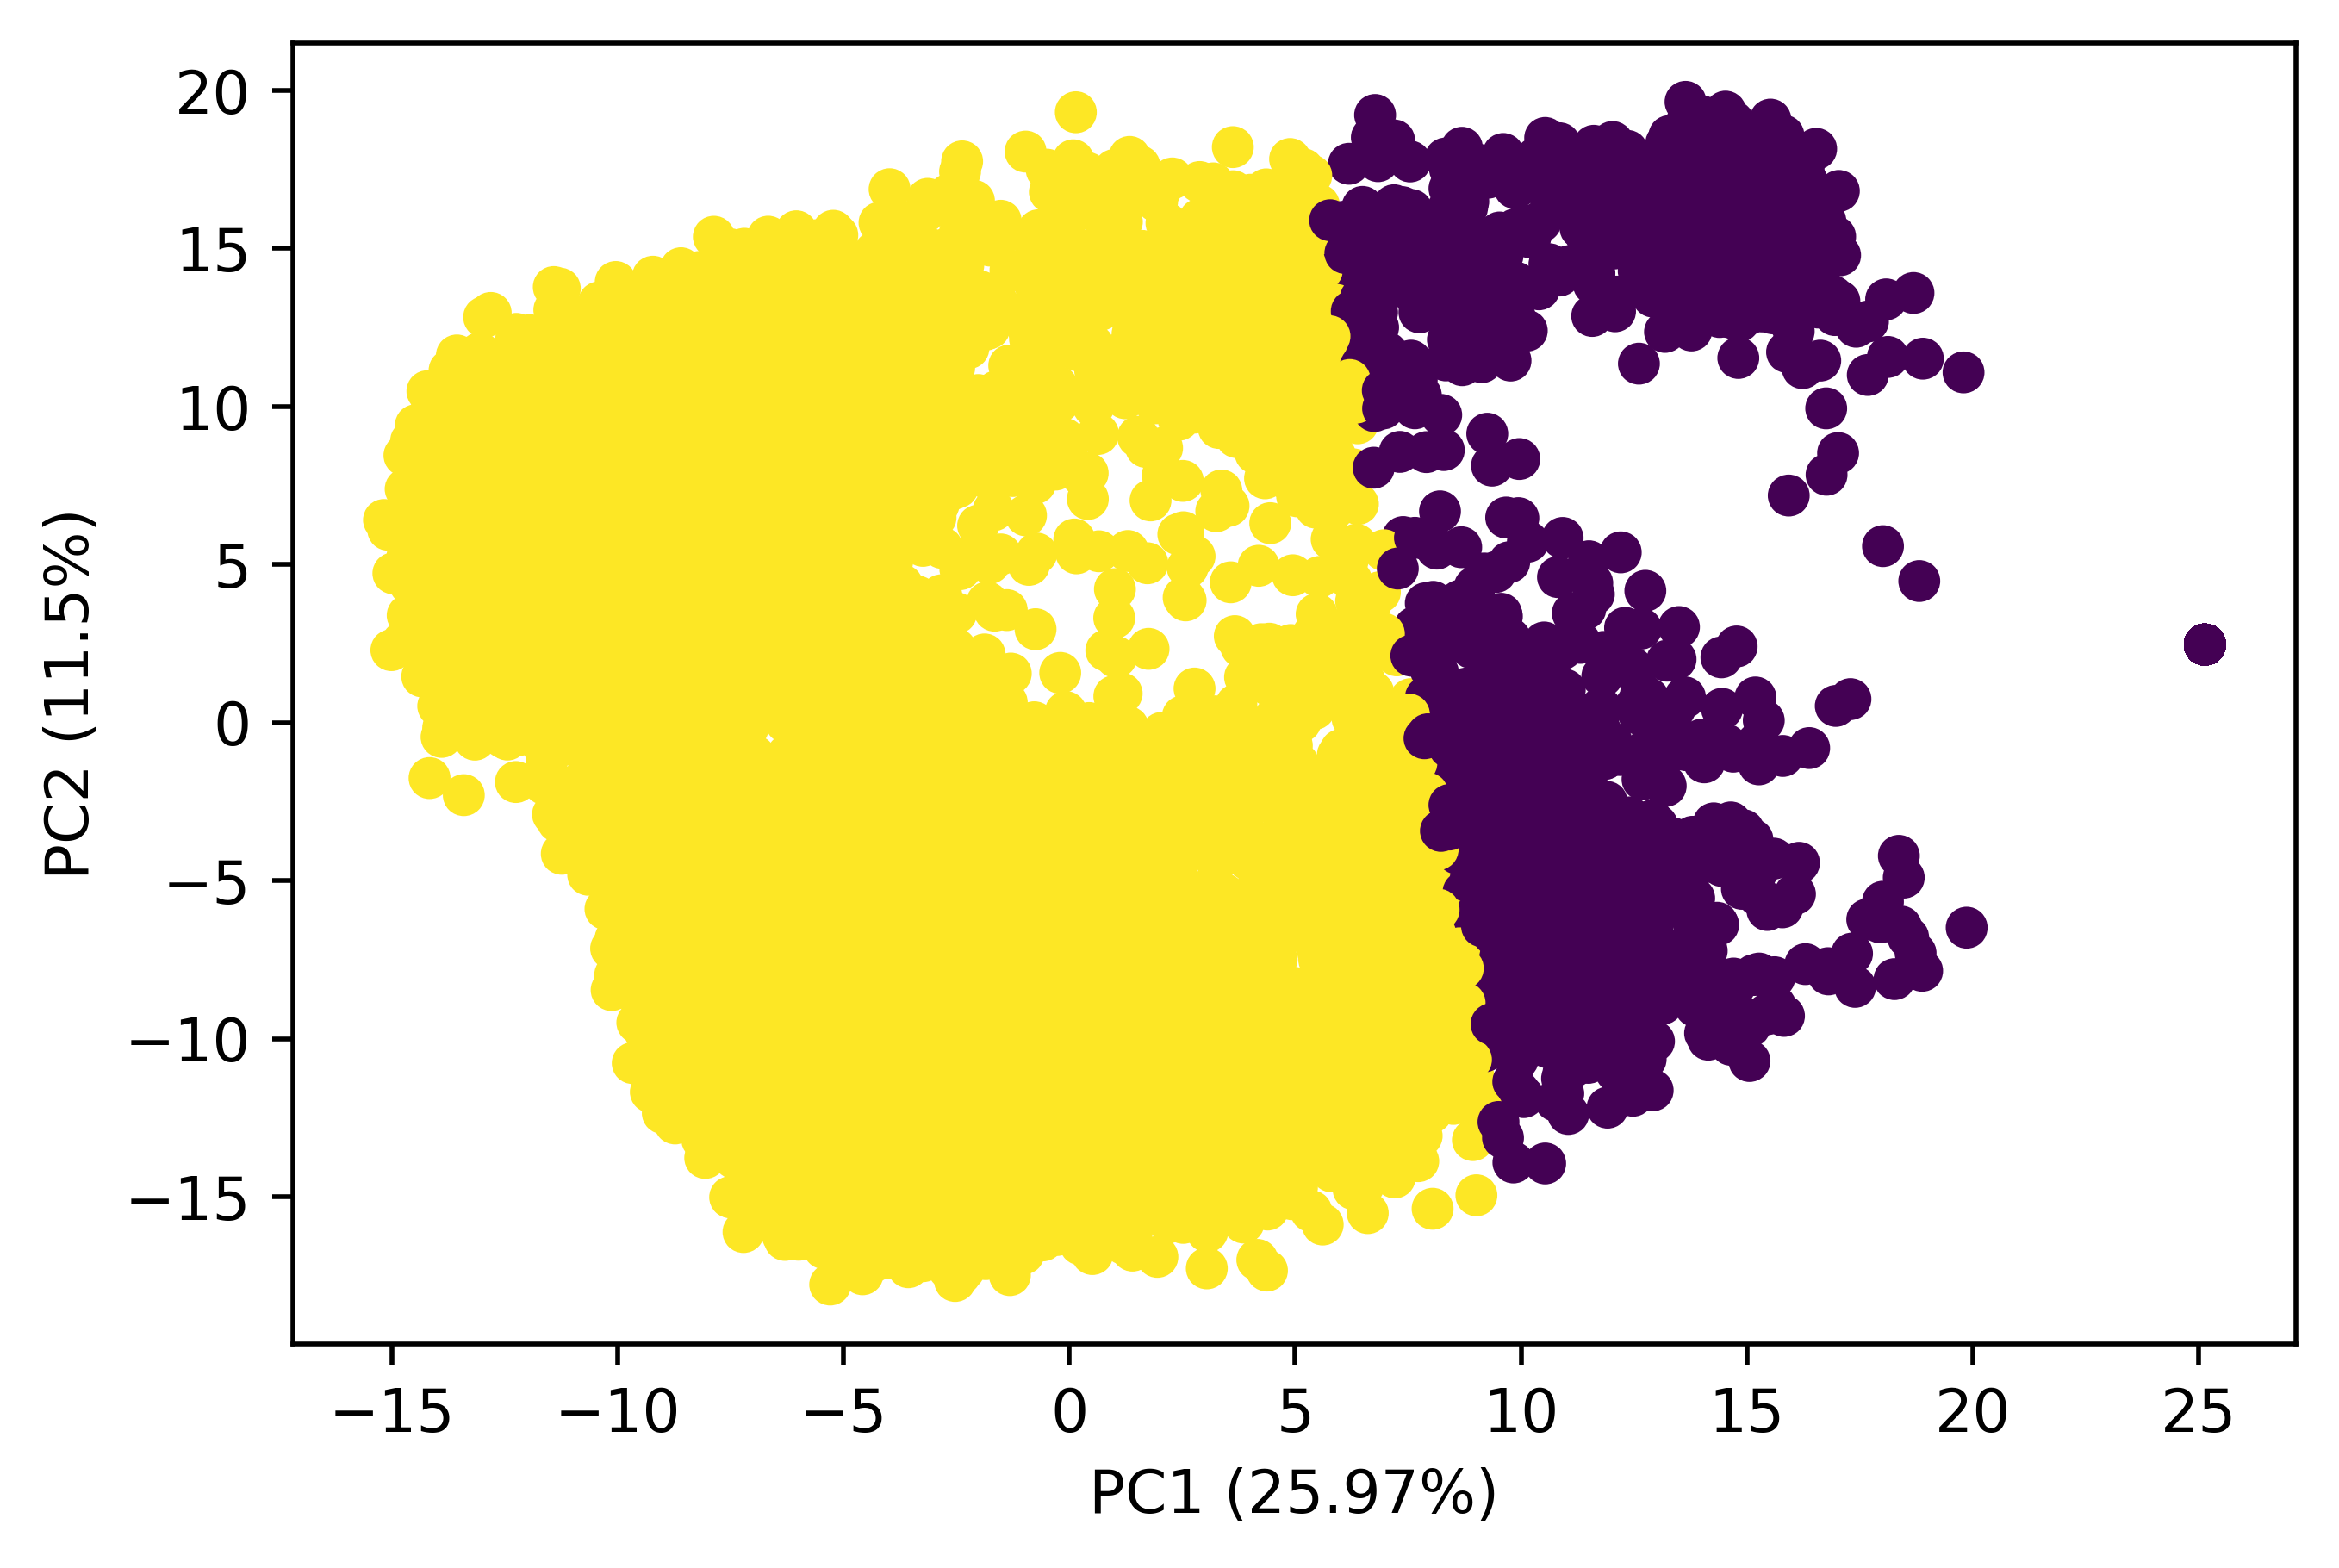

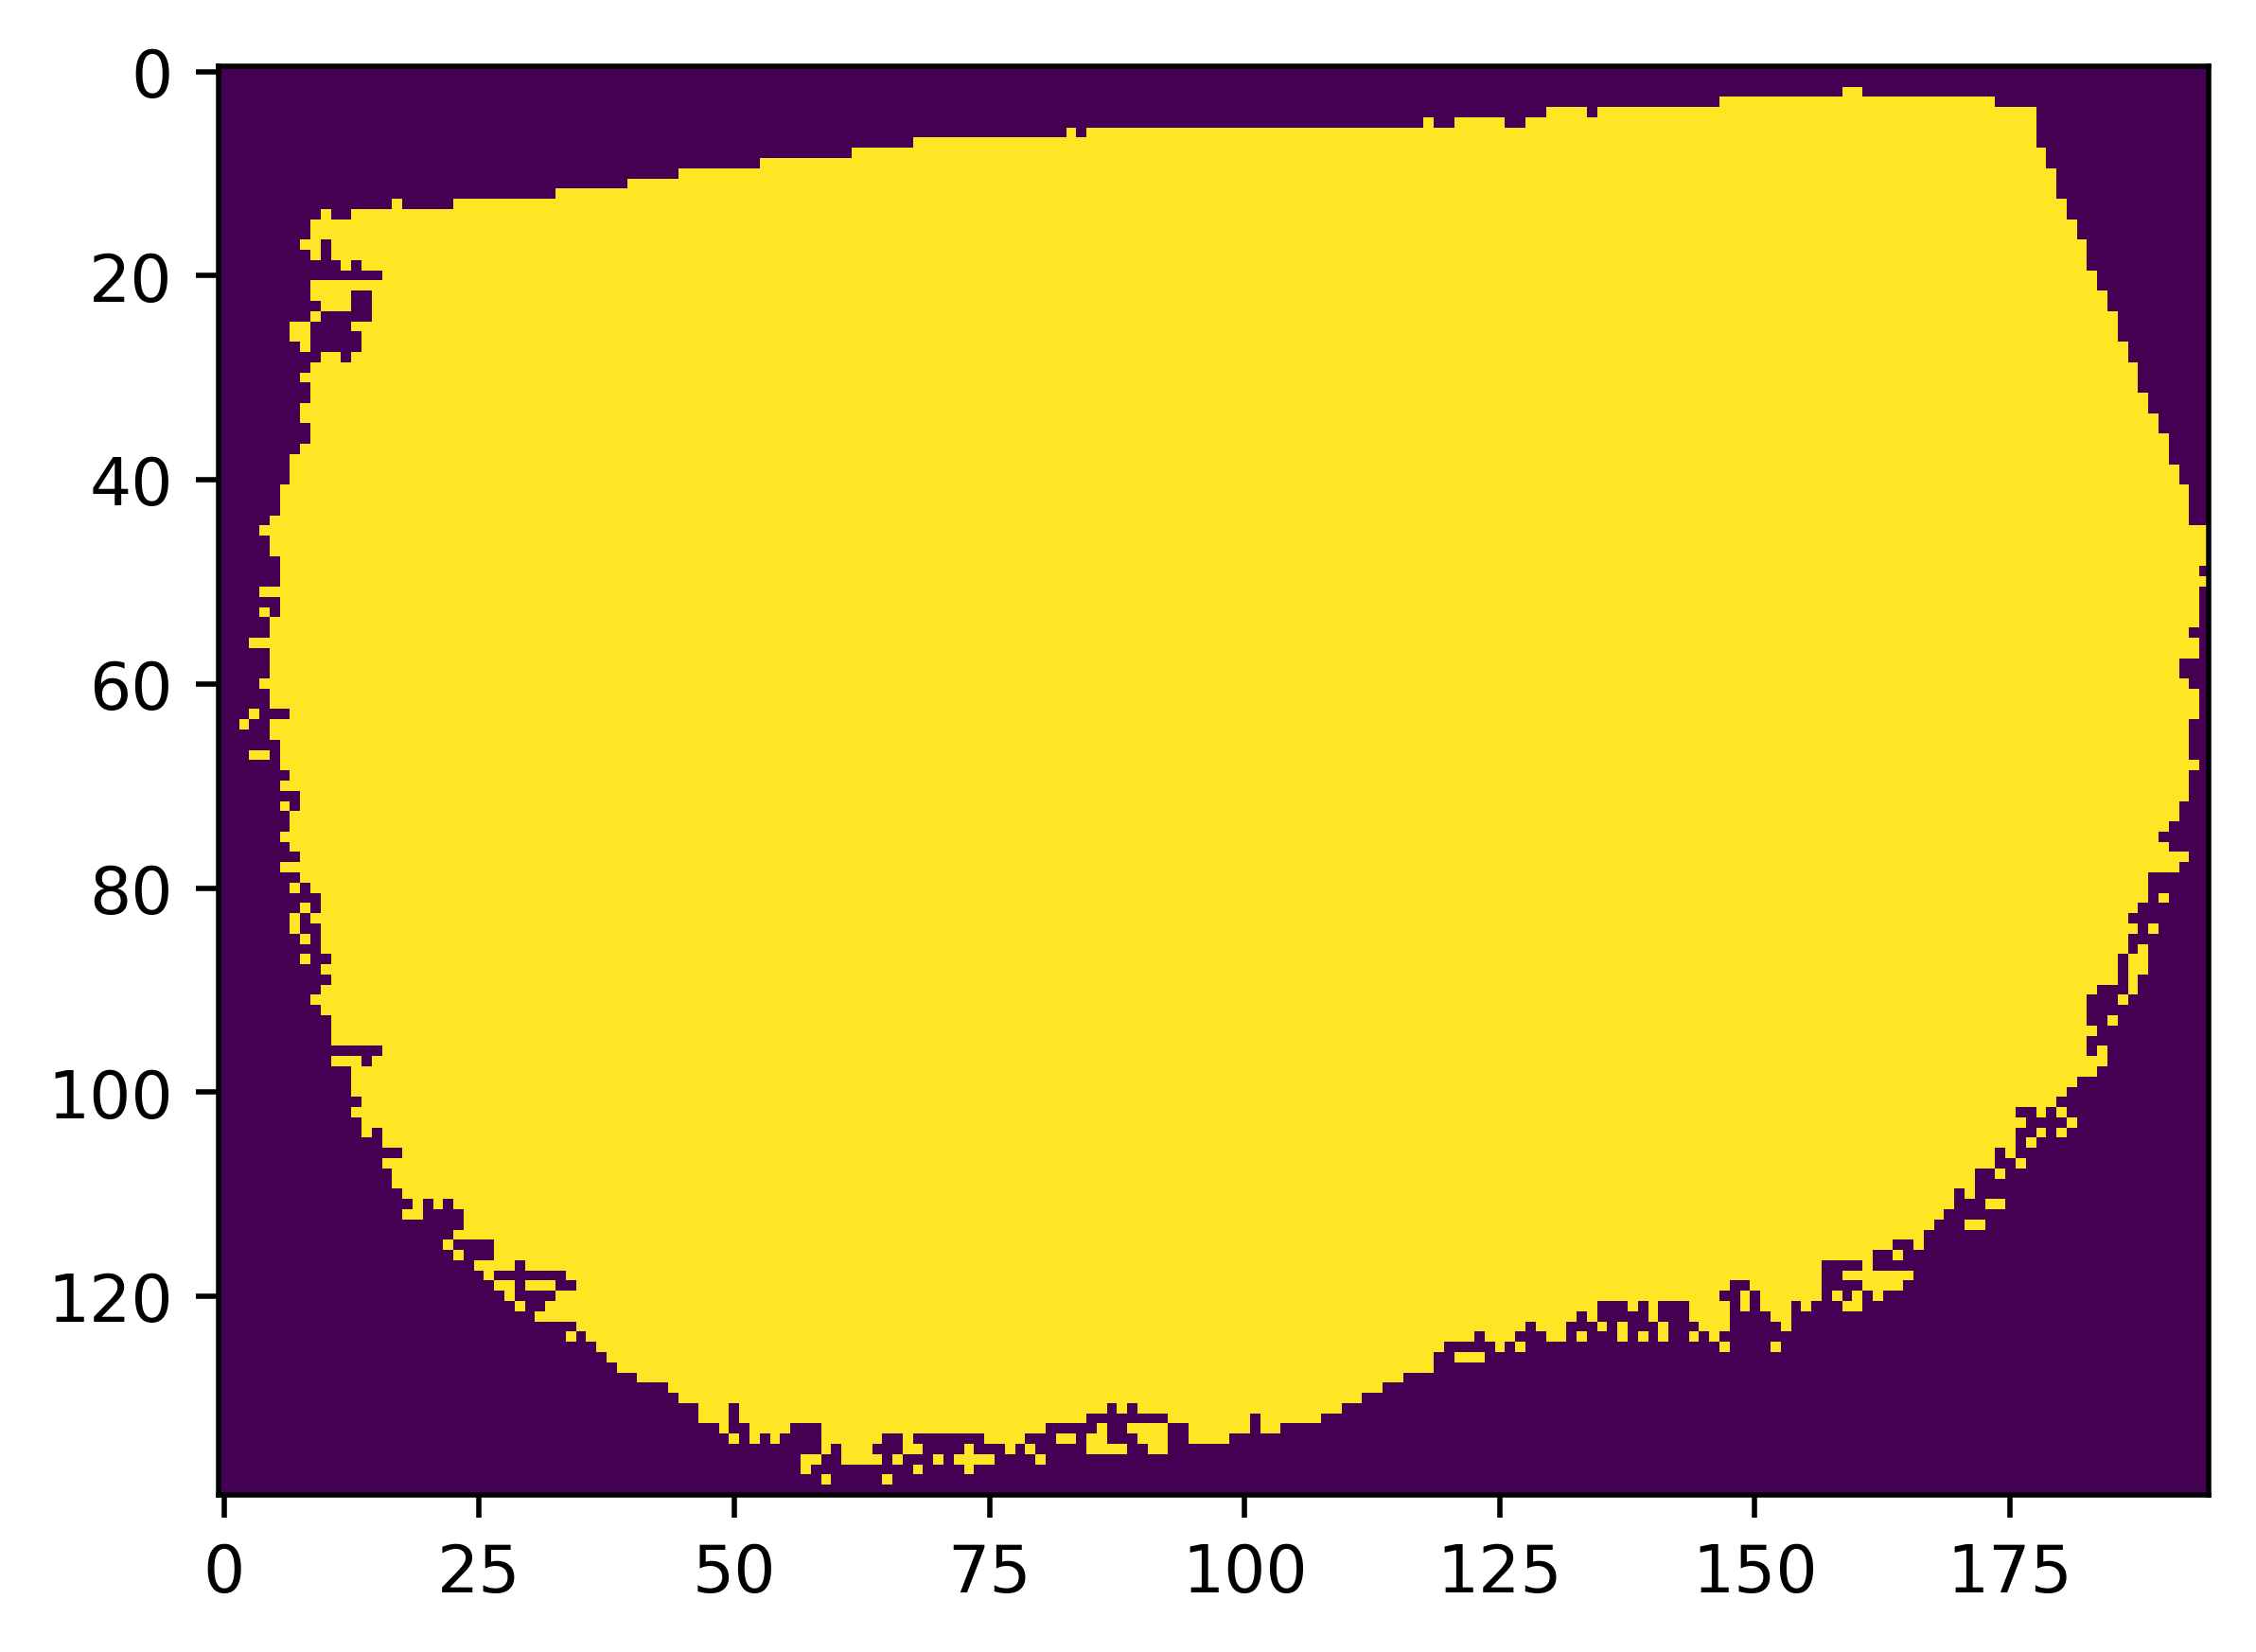

In [35]:
if __name__ == "__main__":
    msis = []
    for file,label,mzList in zip(fns,labels,mzLists):
        msi = SIMSIToolBox.MSIData(mzList,ppm=ppm,numCores = numCores,intensityCutoff=intensityCutoff)
        msi.readimzML(file)
        msi.segmentImage(method="K_means")
        plt.figure()
        plt.imshow(msi.imageBoundary)
        msis.append(msi)

In [61]:
def plotMirror(spec1,spec2,ppm,minMz=50,maxMz=400):
    spec1Mzs = [x for x in list(spec1.keys()) if x > minMz and x < maxMz]
    spec1Mzs.sort()
    spec2Mzs = [x for x in list(spec2.keys()) if x > minMz and x < maxMz]
    spec2Mzs.sort()
    spec1Colors = []
    spec2Colors = []
    for mz in spec1Mzs:
        mz2 = SIMSIToolBox.take_closest(spec2Mzs,mz)
        if np.abs(mz-mz2)/mz * 1e6 < ppm:
            spec1Colors.append("green")
        else:
            spec1Colors.append("blue")
            
    for mz in spec2Mzs:
        mz2 = SIMSIToolBox.take_closest(spec1Mzs,mz)
        if np.abs(mz-mz2)/mz * 1e6 < ppm:
            spec2Colors.append("green")
        else:
            spec2Colors.append("blue")
    
    max1 = np.max([spec1[x] for x in spec1Mzs])
    minMz = np.min(spec1Mzs + spec2Mzs)
    maxMz = np.max(spec1Mzs + spec2Mzs)
    for mz,c in zip(spec1Mzs,spec1Colors):
        #plt.plot([mz,mz],[0,np.log10(spec1[mz])],color=c,linewidth=0.3)
        plt.plot([mz,mz],[0,spec1[mz]/max1],color=c,linewidth=0.3)

    max2 = np.max([spec2[x] for x in spec2Mzs])
    for mz,c in zip(spec2Mzs,spec2Colors):
        #plt.plot([mz,mz],[0,-1*np.log10(spec2[mz])],color=c,linewidth=0.3)
        plt.plot([mz,mz],[0,-1*spec2[mz]/max2],color=c,linewidth=0.3)
    
    plt.plot([minMz,maxMz],[0,0],color="black")
    
def getMeanValueFromBox(arr,xmin,xmax,ymin,ymax):
    roi = []
    for x in range(xmin,xmax+1):
        for y in range(ymin,ymax+1):
            roi.append(arr[x,y])
    roi = np.array(roi)
    return np.mean(roi)

In [59]:
specs = []
for label,mzList,msi in zip(labels,mzLists,msis):
    spec = {}
    for x,mz in enumerate(mzList):
        val = np.mean(msi.data_tensor[x][msi.imageBoundary > 0.5])
        if True:# val > 100:
            spec[mz] = val
    specs.append(spec)

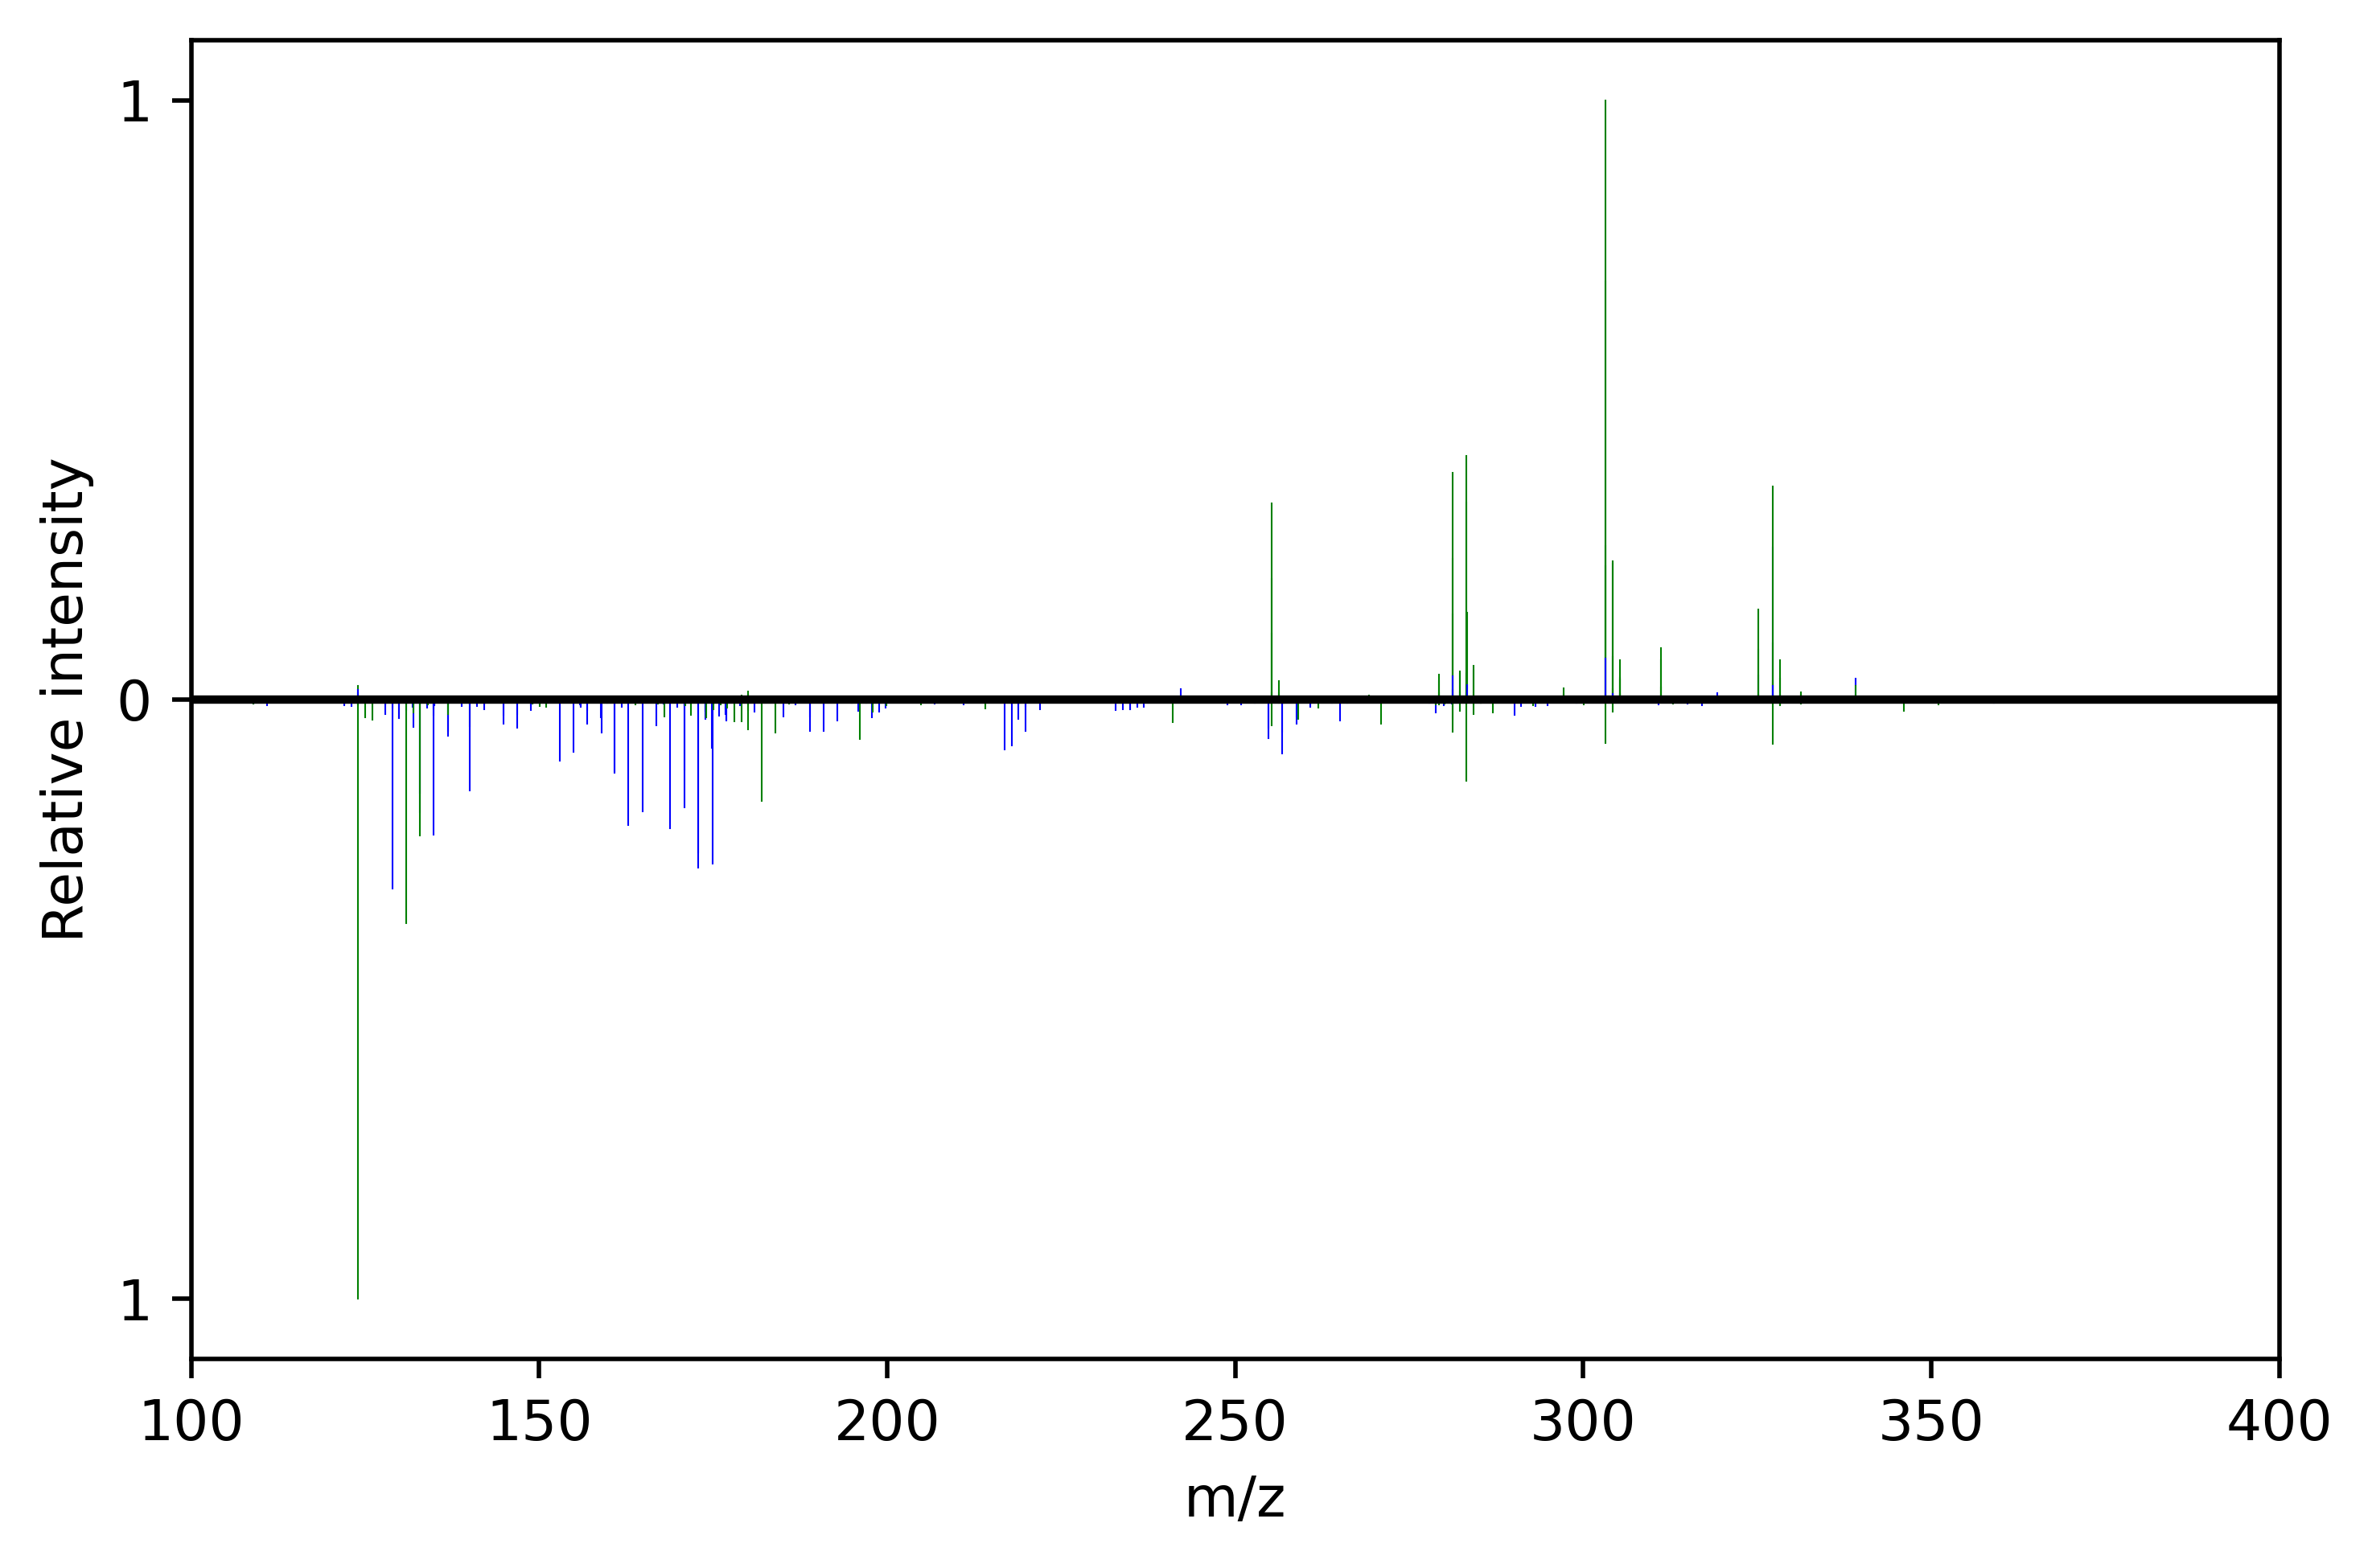

In [62]:
plotMirror(specs[0],specs[1],ppm)
plt.xlim((100,400))
plt.yticks([1,0,-1],labels=[1,0,1])
plt.ylabel("Relative intensity")
plt.xlabel("m/z")
plt.tight_layout()
plt.savefig("../figures_presentations/spectra_comparision_maldi_desi.png")

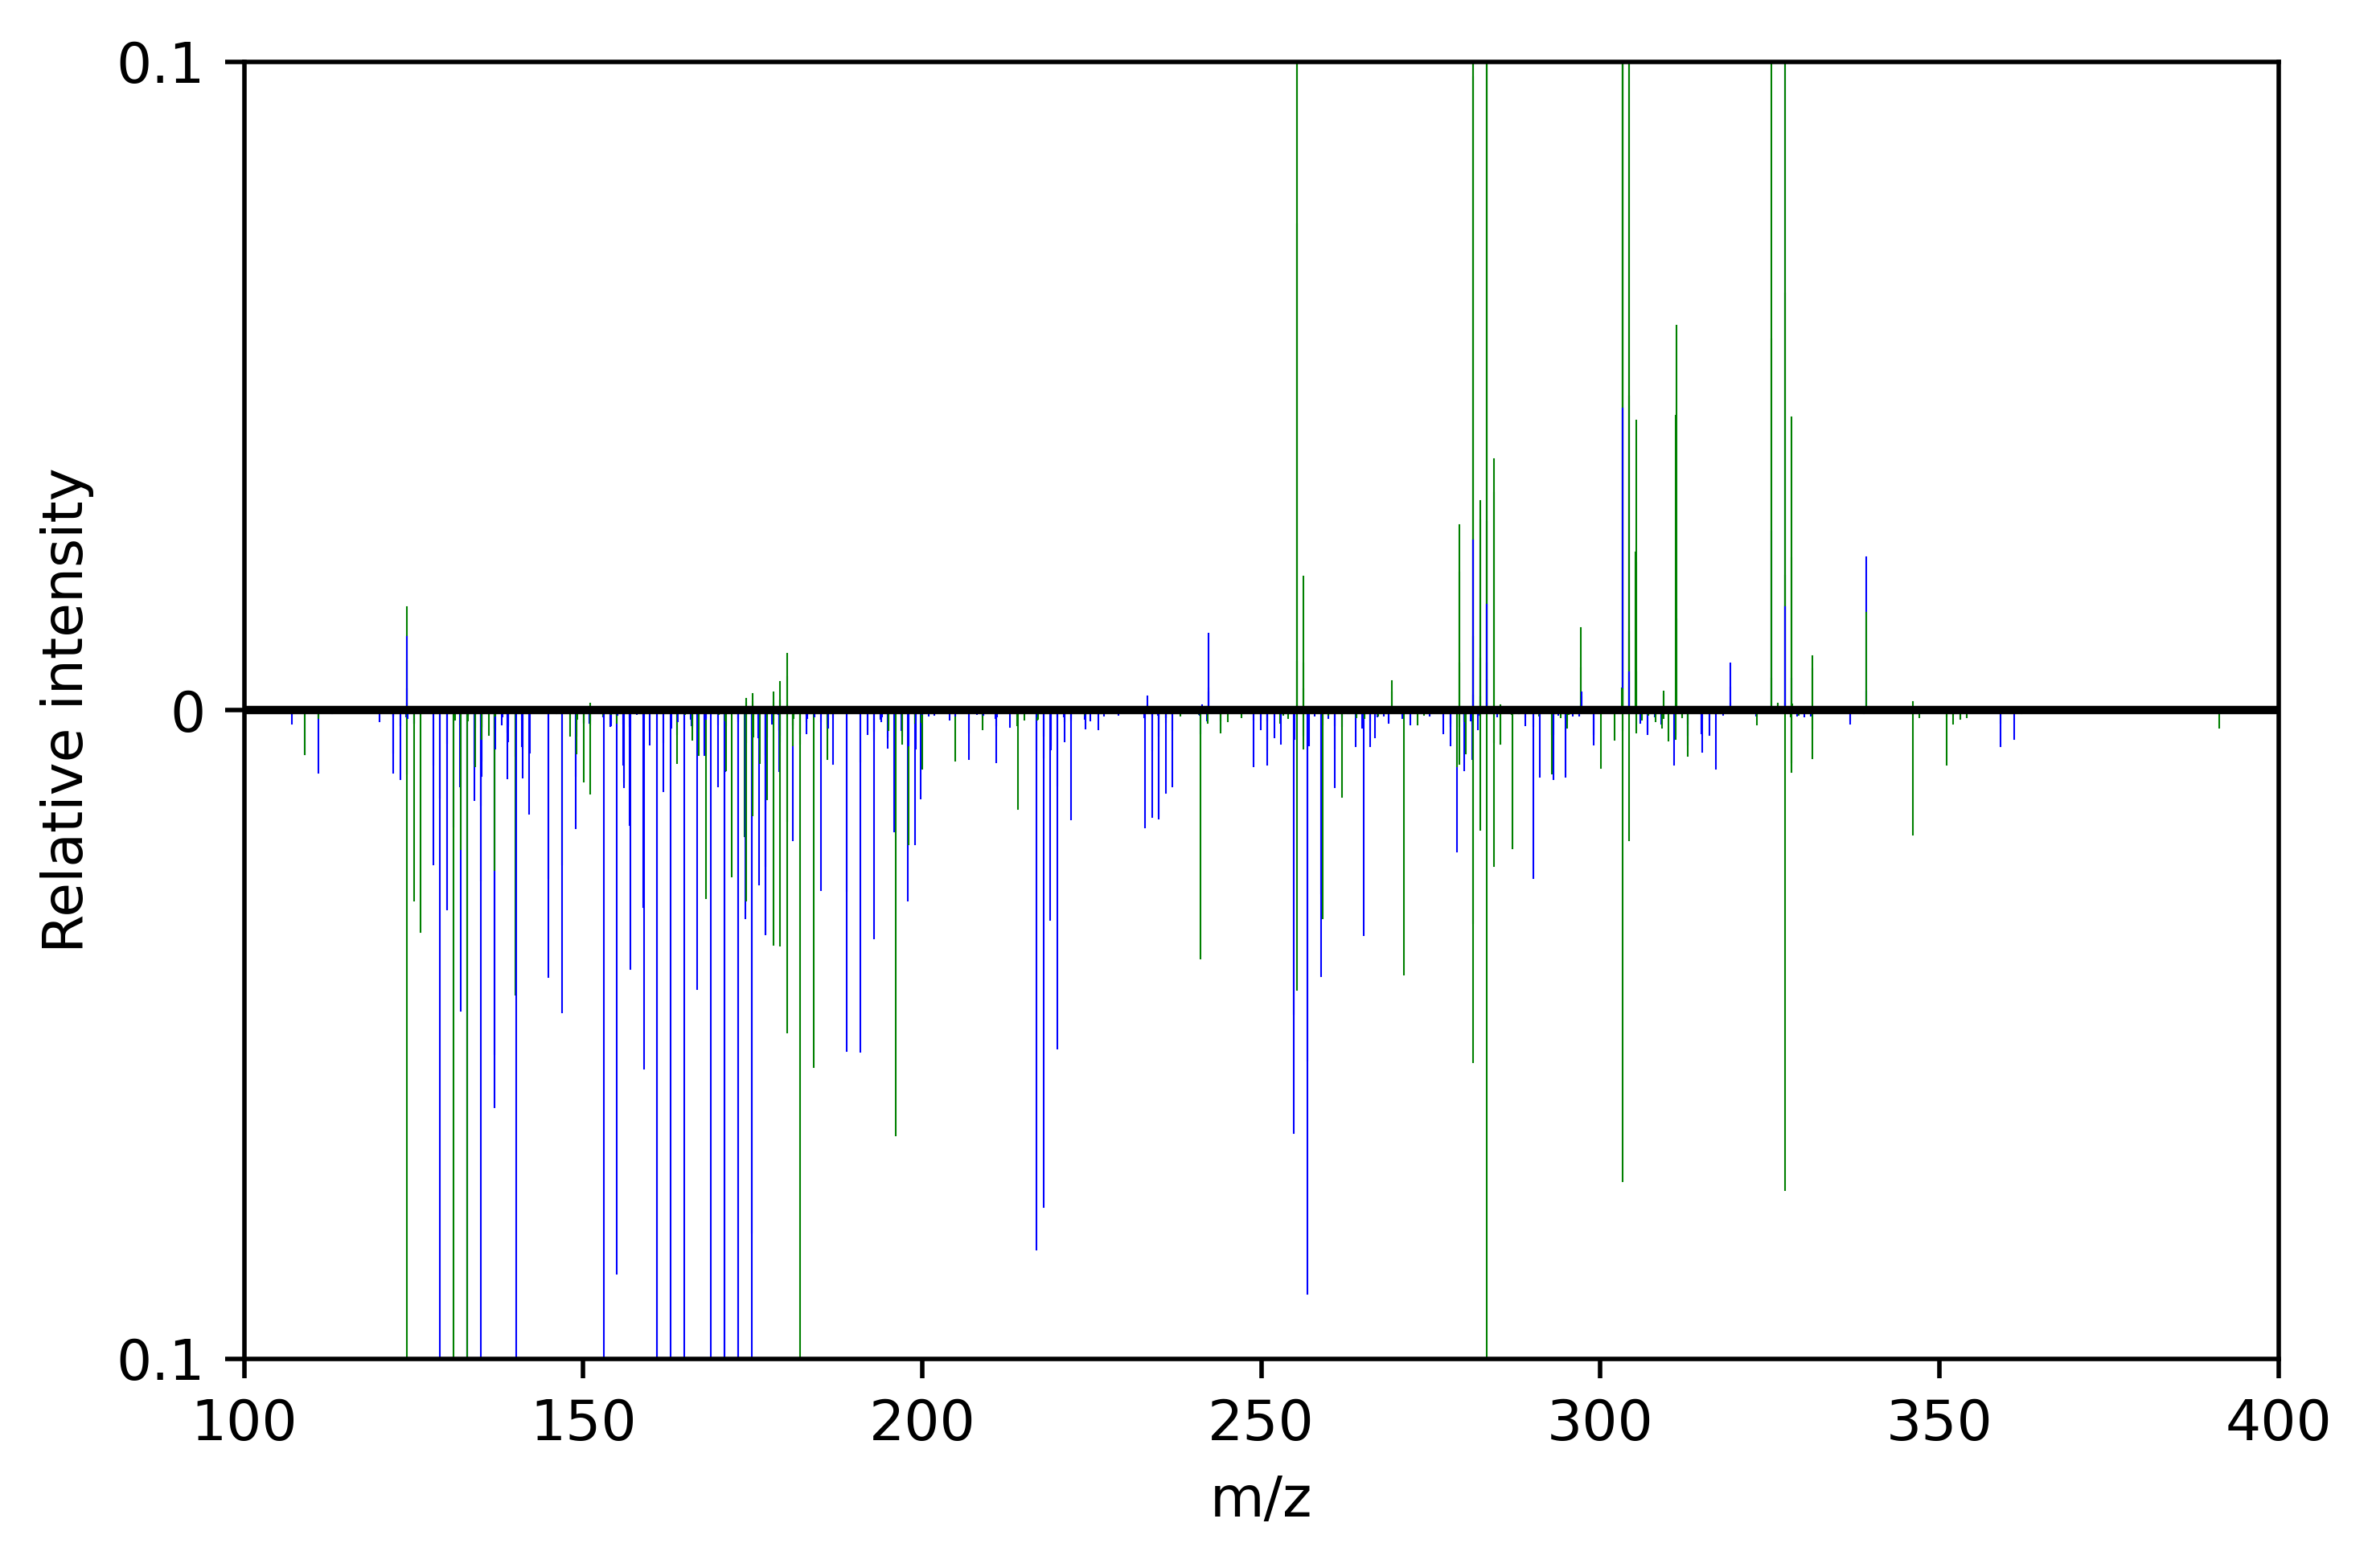

In [56]:
plotMirror(specs[0],specs[1],ppm)
plt.xlim((100,400))
plt.ylim((-0.1,0.1))
plt.yticks([-.1,0,.1],labels=[.1,0,.1])
plt.ylabel("Relative intensity")
plt.xlabel("m/z")
plt.tight_layout()
plt.savefig("../figures_presentations/spectra_comparision_maldi_desi_zoom.png")